I. KẾT NỐI VỚI CƠ SƠR DỮ LIỆU TỪ SQL ĐÃ KẾT NỐI VỚI CLOUD:

In [61]:
# Các thư viện cần thiết
import pyodbc
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import dash
from dash import dcc, html
import dash_bootstrap_components as dbc
import folium
from dash.dependencies import Input, Output
# Cấu hình kết nối
server = 'zillow-crawl-data.database.windows.net'
database = 'Zillow_data'
username = 'zillow'
password = 'Ewddochin2202'
driver = '{ODBC Driver 17 for SQL Server}'
# Tạo kết nối
conn = pyodbc.connect(
    f'DRIVER={driver};SERVER={server};PORT=1433;DATABASE={database};UID={username};PWD={password}'
)


II. THỰC HIỆN LẦN LƯỢT TỪNG BIỂU ĐỒ PHÂN TÍCH

1. Biểu đồ tròn thể hiện tỉ trọng của các loại nhà trong bộ dữ liệu

In [62]:

# Truy vấn dữ liệu từ hai bảng Properties_table & House_Type_table và thực hiện phép JOIN
query1 = """
SELECT ht.House_type, COUNT(p.House_ID) AS Count
FROM Properties_table p
JOIN House_Type_table ht ON p.House_Type_ID = ht.House_Type_ID
GROUP BY ht.House_type
"""
# df1: DataFrame chứa 2 cột: 'House_type' và 'Count'
df1 = pd.read_sql(query1, conn)

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_2896\1390126487.py:9: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



In [63]:
df1.head(6)

,House_type,Count
0,Entry-level House,1601
1,Luxury House,1398
2,Mid-tier House,6203
3,Super-Luxury House,34
4,Ultra-Luxury House,123
5,Upper Mid-tier House,3788


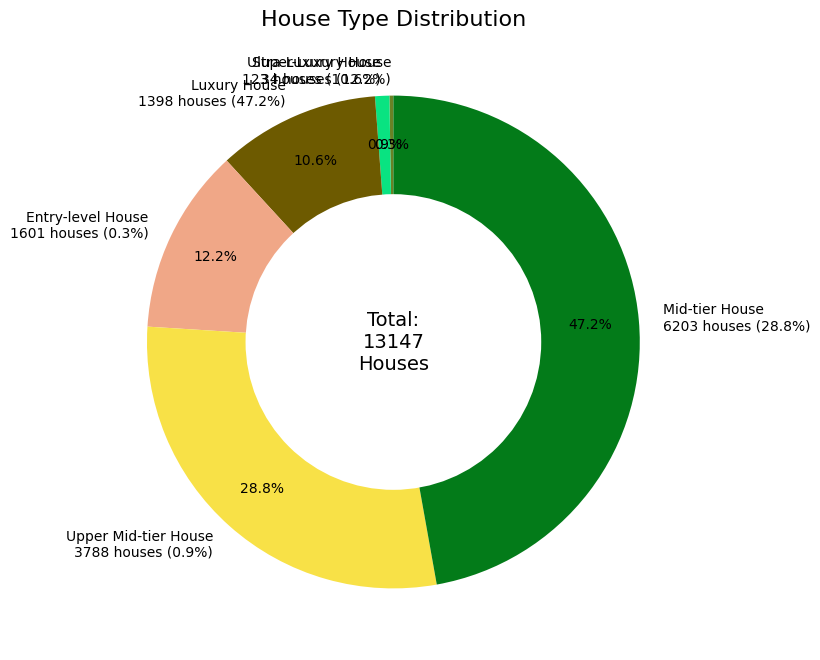

In [64]:
#1 Đếm số lượng nhà theo từng loại dựa trên cột Count
house_counts = df1.set_index('House_type')['Count']
house_percents = house_counts / house_counts.sum() * 100
#2 Định nghĩa màu sắc cho từng loại nhà
house_colors = {
    'Mid-tier House': '#037B19',       
    'Upper Mid-tier House': '#F8E147', 
    'Entry-level House': '#F0A787',    
    'Luxury House': '#6D5A00',         
    'Ultra-Luxury House': '#09E381',   
    'Super-Luxury House': '#698225'    
}
#3 Sắp xếp các loại nhà theo số lượng tăng dần
house_counts = house_counts.sort_values()
#4 Hàm vẽ biểu đồ donut
def plot_donut(house_counts, house_colors):
    #a Chuẩn bị dữ liệu để hiển thị
    labels = [
        f"{house_type}\n{count} houses ({percent:.1f}%)"
        for house_type, count, percent in zip(
            house_counts.index, house_counts.values, house_percents
        )
    ]
    sizes = house_counts.values
    colors = [house_colors.get(house_type, '#FFFFFF') for house_type in house_counts.index]
    
    #b Vẽ biểu đồ tròn
    fig, ax = plt.subplots(figsize=(8, 8))  # Tăng kích thước biểu đồ
    wedges, texts, autotexts = ax.pie(
        sizes,
        labels=labels,
        autopct='%1.1f%%',
        startangle=90,
        colors=colors,
        pctdistance=0.8,  # Điều chỉnh vị trí phần trăm
        textprops={'fontsize': 10}  # Cỡ chữ phần trăm
    )
    ax.set(aspect="equal")  # Đảm bảo biểu đồ tròn

    #c Tạo vòng tròn trắng bên trong (donut)
    centre_circle = plt.Circle((0, 0), 0.60, fc='white')  # Điều chỉnh bán kính
    fig.gca().add_artist(centre_circle)

    #d Thêm số liệu tổng số nhà ở giữa
    total = house_counts.sum()
    ax.text(0, 0, f"Total:\n{total}\nHouses", ha='center', va='center', fontsize=14)

    #e Tiêu đề biểu đồ
    plt.title('House Type Distribution', fontsize=16)
    plt.show()

#5 Gọi hàm để vẽ biểu đồ
plot_donut(house_counts, house_colors)


2. Biểu đồ thể hiện phân phối giá nhà trung bình và diện tích trung bình

In [65]:
# Truy vấn cột Price từ bảng Properties_table
query2 = "SELECT Price FROM Properties_table"
df2 = pd.read_sql(query2, conn)

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_2896\1564380754.py:3: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



In [66]:
df2.head()
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13147 entries, 0 to 13146
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   13147 non-null  float64
dtypes: float64(1)
memory usage: 102.8 KB


In [67]:
#1 Tính giá trị trung bình của cột 'price' (giả sử bạn đã có dữ liệu trong df)
average_price = df2['Price'].mean()

#2 Vẽ biểu đồ Gauge với màu xanh #037B19
fig = go.Figure(go.Indicator(
    mode="gauge+number",
    value=average_price,
    title={'text': "Average House Price"},
    gauge={
        'shape': 'angular',
        'axis': {'range': [0, average_price]},  # Giới hạn từ 0 đến giá trị trung bình
        'bar': {'color': '#037B19'},  # Màu thanh gauge
        'steps': [
            {'range': [0, average_price], 'color': '#037B19'}  # Bước màu xanh từ 0 đến giá trị trung bình
        ]
    },
    number={'font': {'size': 20, 'color': 'red'}, 'suffix': ' USD'}
))
fig.update_layout(
    height=300,  # Chiều cao (giảm giá trị này để chiều cao nhỏ hơn)
    width=450    # Chiều rộng (giữ nguyên hoặc chỉnh tùy ý)
)
#3 Hiển thị biểu đồ
fig.show()


In [68]:
# Truy vấn cột [Sqft] từ bảng Properties_table
query3 = "SELECT [Sqft] FROM Properties_table"
df3 = pd.read_sql(query3, conn)

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_2896\1290827128.py:3: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



In [69]:
df3.head()

,Sqft
0,1364.0
1,3079.0
2,7086.0
3,905.0
4,1330.0


In [70]:
#1 Tính giá trị trung bình của cột 'price' (giả sử bạn đã có dữ liệu trong df)
average_sqft = df3['Sqft'].mean()

#2 Vẽ biểu đồ Gauge với màu xanh #037B19
fig = go.Figure(go.Indicator(
    mode="gauge+number",
    value= average_sqft,
    title={'text': "Average House Square_Footage"},
    gauge={
        'shape': 'angular',
        'axis': {'range': [0, average_sqft]},  # Giới hạn từ 0 đến giá trị trung bình
        'bar': {'color': '#037B19'},  # Màu thanh gauge
        'steps': [
            {'range': [0, average_sqft], 'color': '#037B19'}  # Bước màu xanh từ 0 đến giá trị trung bình
        ]
    },
    number={'font': {'size': 20, 'color': 'red'}, 'suffix': ''}
))
fig.update_layout(
    height=300,  # Chiều cao (giảm giá trị này để chiều cao nhỏ hơn)
    width=450    # Chiều rộng (giữ nguyên hoặc chỉnh tùy ý)
)
#3 Hiển thị biểu đồ
fig.show()


3. Biều đồ phễu thể hiện Top 5 thành phố có mức giá trung bình cao nhất

In [71]:
# Truy vấn dữ liệu từ hai bảng
query4 = """
SELECT c.City, p.Price
FROM Properties_table AS p
JOIN City_table AS c ON p.City_ID = c.City_ID
"""
df4 = pd.read_sql(query4, conn)

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_2896\220484896.py:7: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



In [72]:
df4.info()
df4.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13147 entries, 0 to 13146
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   City    13147 non-null  object 
 1   Price   13147 non-null  float64
dtypes: float64(1), object(1)
memory usage: 205.6+ KB


,City,Price
0,Des Moines,275000.0
1,Minneapolis,1850000.0
2,Lincoln,2199000.0
3,Philadelphia,279000.0
4,Philadelphia,299000.0


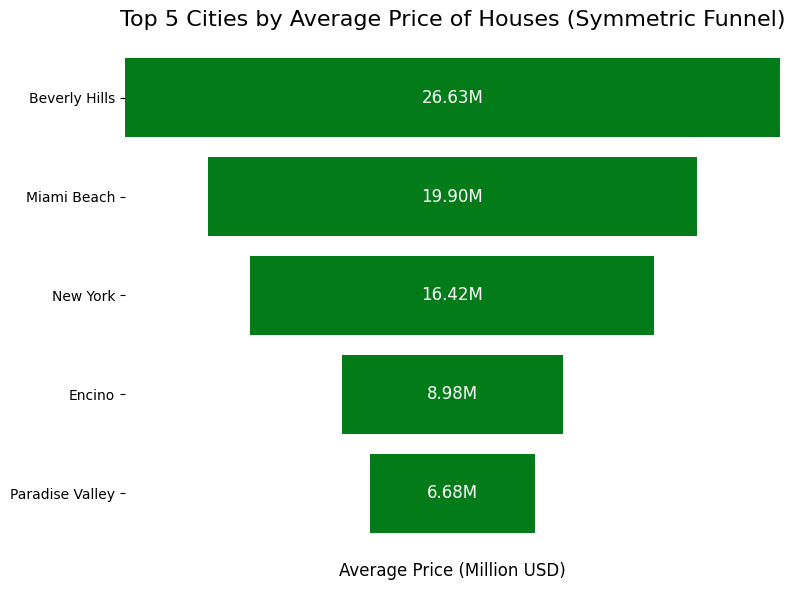

In [73]:
#1: Tính giá trung bình cho từng thành phố
city_avg_price = df4.groupby('City')['Price'].mean().reset_index()

#2: Sắp xếp và lấy top 5 thành phố có giá trung bình cao nhất
top5_cities = city_avg_price.sort_values(by='Price', ascending=False).head(5)

#3: Chuẩn bị dữ liệu để vẽ
cities = top5_cities['City']  # Tên thành phố
avg_prices = top5_cities['Price'] / 1e6  # Chuyển đổi sang triệu USD

#4: Vẽ biểu đồ phễu tam giác cân
fig, ax = plt.subplots(figsize=(8, 6))

 ##Tạo các thanh tam giác cân
max_width = max(avg_prices)  # Độ rộng lớn nhất
for i, (city, price) in enumerate(zip(cities, avg_prices)):
    left = (max_width - price) / 2  # Đặt thanh sao cho cân đối ở giữa
    ax.barh(city, price, left=left, color='#037B19', height=0.8)

    # Thêm nhãn giá trị bên trong thanh
    ax.text(max_width / 2, i, f'{price:.2f}M', va='center', ha='center',
            fontsize=12, color='white')

 ##Định dạng biểu đồ
ax.set_title('Top 5 Cities by Average Price of Houses (Symmetric Funnel)', fontsize=16)
ax.set_xlabel('Average Price (Million USD)', fontsize=12)
ax.set_xlim(0, max_width)
ax.set_xticks([])
ax.invert_yaxis()  # Đảo ngược thứ tự thành phố

 ##Tắt khung và trục không cần thiết
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.tight_layout()
plt.show()

4. Biểu đồ thể hiện mối liên hệ giữa số phòng ngủ với giá và diện tích trung bình

In [74]:
# Truy vấn dữ liệu từ bảng Properties_table và Properties_Details_table
query5 = """
SELECT 
    pd.Bedroom,
    p.Price,
    p.Sqft
FROM 
    Properties_table AS p
JOIN 
    Properties_Details_table AS pd ON p.House_ID = pd.House_ID
WHERE 
    pd.Bedroom < 10
"""
df5 = pd.read_sql(query5, conn)

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_2896\563969483.py:14: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



In [75]:
df5.head()

,Bedroom,Price,Sqft
0,3,275000.0,1364.0
1,2,1850000.0,3079.0
2,7,2199000.0,7086.0
3,2,279000.0,905.0
4,3,299000.0,1330.0


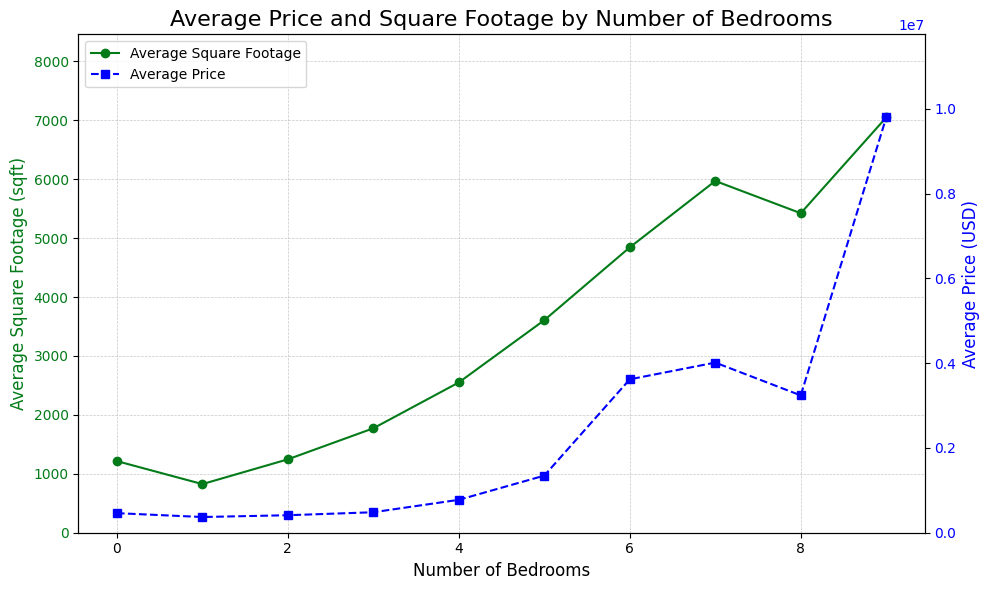

In [76]:
import pandas as pd
import matplotlib.pyplot as plt
#1 Tính giá trung bình và diện tích trung bình theo số phòng ngủ
avg_data = df5.groupby('Bedroom').agg({
    'Price': 'mean',
    'Sqft': 'mean'
}).reset_index()

#2 Trích xuất dữ liệu
bedrooms = avg_data['Bedroom']
avg_price = avg_data['Price']
avg_area = avg_data['Sqft']

#3 Vẽ biểu đồ đường
fig, ax1 = plt.subplots(figsize=(10, 6))

#4 Trục y thứ nhất: Diện tích trung bình
color_area = '#037B19'
ax1.set_xlabel('Number of Bedrooms', fontsize=12)
ax1.set_ylabel('Average Square Footage (sqft)', color=color_area, fontsize=12)
line1 = ax1.plot(
    bedrooms, avg_area, color=color_area, marker='o', label='Average Square Footage'
)
ax1.tick_params(axis='y', labelcolor=color_area)
ax1.set_ylim(0, max(avg_area) * 1.2)  # Thêm khoảng trống trên trục y (20%)
ax1.grid(visible=True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

#5 Trục y thứ hai: Giá trung bình
ax2 = ax1.twinx()
color_price = 'blue'
ax2.set_ylabel('Average Price (USD)', color=color_price, fontsize=12)
line2 = ax2.plot(
    bedrooms, avg_price, color=color_price, marker='s', linestyle='--', label='Average Price'
)
ax2.tick_params(axis='y', labelcolor=color_price)
ax2.set_ylim(0, max(avg_price) * 1.2)  # Thêm khoảng trống trên trục y (20%)

#6 Gộp legend từ cả hai trục
lines = line1 + line2
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper left', fontsize=10)

#7 Định dạng biểu đồ
plt.title('Average Price and Square Footage by Number of Bedrooms', fontsize=16)
plt.tight_layout()

#8 Hiển thị biểu đồ
plt.show()

In [77]:
# Thực thi câu lệnh SQL
query6 = """
SELECT 
    c.City, 
    ht.House_Type, 
    COUNT(*) AS House_Count
FROM 
    Properties_table AS p
JOIN 
    City_table AS c ON p.City_id = c.City_id
JOIN 
    House_Type_table AS ht ON p.House_Type_id = ht.House_Type_id
GROUP BY 
    c.City, ht.House_Type
ORDER BY 
    c.City, House_Count DESC;
"""

# Đọc dữ liệu vào DataFrame
df6 = pd.read_sql(query6, conn)

# Kiểm tra dữ liệu
print(df6.head())

       City            House_Type  House_Count
0  Aberdeen     Entry-level House            1
1   Abilene        Mid-tier House           80
2   Abilene     Entry-level House           40
3   Abilene  Upper Mid-tier House           16
4   Abilene          Luxury House            1


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_2896\3961869004.py:20: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



6. Biểu đồ cột chồng thể hiện phân phối của các loại nhà trong mỗi thành phố

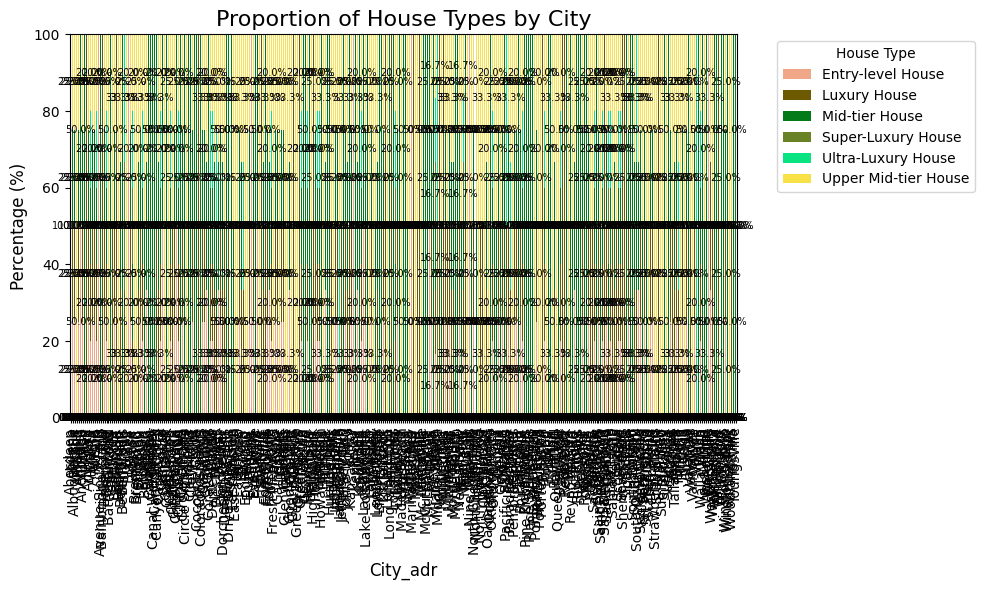

In [78]:
#1: Tính tổng số nhà theo từng thành phố và loại nhà
house_counts = df6.groupby(['City', 'House_Type']).size().reset_index(name='House_Count')

#2: Tính tỷ trọng (%) của từng loại nhà trong mỗi thành phố
city_totals = house_counts.groupby('City')['House_Count'].transform('sum')  # Tổng số nhà trong từng thành phố
house_counts['Percentage'] = (house_counts['House_Count'] / city_totals) * 100

#3: Chuẩn bị dữ liệu để vẽ biểu đồ dạng stacked bar
pivot_data = house_counts.pivot(index='City', columns='House_Type', values='Percentage').fillna(0)

#4: Vẽ biểu đồ stacked bar
fig, ax = plt.subplots(figsize=(10, 6))
 ##Vẽ các thanh cho từng loại nhà
colors = {
    'Mid-tier House': '#037B19',    # Mid
    'Upper Mid-tier House': '#F8E147',        # Upper Mid
    'Entry-level House': '#F0A787',    # Entry
    'Luxury House': '#6D5A00',        # Lux
    'Ultra-Luxury House': '#09E381',    # Ultra Lux
    'Super-Luxury House': '#698225'       # Super Lux
}

 ##Vẽ biểu đồ stacked bar
pivot_data.plot(kind='bar', stacked=True, color=[colors[col] for col in pivot_data.columns], ax=ax)

 ##Định dạng biểu đồ
ax.set_title('Proportion of House Types by City', fontsize=16)
ax.set_ylabel('Percentage (%)', fontsize=12)
ax.set_xlabel('City_adr', fontsize=12)
ax.legend(title='House Type', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
ax.set_ylim(0, 100)  # Biểu đồ theo tỷ lệ 100%

##Hiển thị tỷ lệ phần trăm trên thanh
for bar in ax.containers:
    ax.bar_label(bar, fmt='%.1f%%', label_type='center', fontsize=7)

plt.tight_layout()
plt.show()


7. Biểu đồ bàn đồ thể hiện vị trí phân bố của các ngôi nhà trong bộ dữ liệu

In [79]:
# Lấy dữ liệu từ các bảng
query7 ='''
SELECT 
    p.Street_adr,
    c.City,
    s.State_name,
    p.Price,
    p.Sqft
FROM 
    Properties_table AS p
JOIN 
    City_table AS c ON p.City_ID = c.City_ID
JOIN 
    State_table AS s ON c.State_ID = s.State_ID
'''

df7 = pd.read_sql(query7, conn)

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_2896\111505872.py:17: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



In [80]:
df7.head(100)

,Street_adr,City,State_name,Price,Sqft
0,6812 Sweetwater Dr,Des Moines,IA,275000.0,1364.0
1,201 11th St S #2600,Minneapolis,MN,1850000.0,3079.0
2,2255 SW 47th St,Lincoln,NE,2199000.0,7086.0
3,104 Sigel St,Philadelphia,PA,279000.0,905.0
4,212 Sigel St,Philadelphia,PA,299000.0,1330.0
...,...,...,...,...,...
95,1135 SW 5th Ter,Cape Coral,FL,648900.0,1941.0
96,522 SW 28th Ter,Cape Coral,FL,630000.0,1931.0
97,3574 NE 10th Pl,Cape Coral,FL,469500.0,1469.0
98,737 E Hilton St,Philadelphia,PA,65000.0,1126.0


In [81]:
import pandas as pd
import folium
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
import time

#1 Lấy 50 dòng đầu tiên
df7 = df7.head(100)

#2 Tạo cột địa chỉ đầy đủ
df7['Full_Address'] = df7['Street_adr'] + ', ' + df7['City'] + ', ' + df7['State_name']

#3 Sử dụng geopy để lấy tọa độ (latitude và longitude)
geolocator = Nominatim(user_agent="geoapi")

#4 Hàm lấy tọa độ, xử lý lỗi Timeout
def get_coordinates(address, index):
    try:
        print(f"Đang quét dòng {index}")  # Thông báo trạng thái
        location = geolocator.geocode(address, timeout=5)
        if location:
            return location.latitude, location.longitude
        else:
            return None, None
    except GeocoderTimedOut:
        print(f"Lỗi timeout tại dòng {index}, thử lại sau.")  # Thông báo lỗi
        return None, None

#5 Duyệt từng dòng và lấy tọa độ
latitude_list = []
longitude_list = []

for index, row in df7.iterrows():
    lat, lon = get_coordinates(row['Full_Address'], index)
    latitude_list.append(lat)
    longitude_list.append(lon)
    time.sleep(3)  # Nghỉ 3 giây giữa các request để tránh bị chặn API

#6 Thêm tọa độ vào DataFrame
df7['Latitude'] = latitude_list
df7['Longitude'] = longitude_list

#7 Loại bỏ các hàng không có tọa độ
df = df7.dropna(subset=['Latitude', 'Longitude'])

#8 Tạo bản đồ với folium
map_center = [df7['Latitude'].mean(), df7['Longitude'].mean()]  # Tâm bản đồ là tọa độ trung bình
folium_map = folium.Map(location=map_center, zoom_start=10)

#9 Thêm các điểm marker vào bản đồ
for index, row in df.iterrows():
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=(
            f"Address: {row['Full_Address']}<br>"
            f"Price: {row['Price']}$<br>"
            f"Square Footage: {row['Sqft']} sqft"
        ),
        tooltip="Click for details"
    ).add_to(folium_map)

#10 Lưu bản đồ vào file HTML
folium_map.save("map.html")

##Hiển thị bản đồ (nếu bạn đang dùng Jupyter Notebook)
folium_map

Đang quét dòng 0
Đang quét dòng 1
Đang quét dòng 2
Đang quét dòng 3
Đang quét dòng 4
Đang quét dòng 5
Đang quét dòng 6
Đang quét dòng 7
Đang quét dòng 8
Đang quét dòng 9
Đang quét dòng 10
Đang quét dòng 11
Đang quét dòng 12
Đang quét dòng 13
Đang quét dòng 14
Đang quét dòng 15
Đang quét dòng 16
Đang quét dòng 17
Đang quét dòng 18
Đang quét dòng 19
Đang quét dòng 20
Đang quét dòng 21
Đang quét dòng 22
Đang quét dòng 23
Đang quét dòng 24
Đang quét dòng 25
Đang quét dòng 26
Đang quét dòng 27
Đang quét dòng 28
Đang quét dòng 29
Đang quét dòng 30
Đang quét dòng 31
Đang quét dòng 32
Đang quét dòng 33
Đang quét dòng 34
Đang quét dòng 35
Đang quét dòng 36
Đang quét dòng 37
Đang quét dòng 38
Đang quét dòng 39
Đang quét dòng 40
Đang quét dòng 41
Đang quét dòng 42
Đang quét dòng 43
Đang quét dòng 44
Đang quét dòng 45
Đang quét dòng 46
Đang quét dòng 47
Đang quét dòng 48
Đang quét dòng 49
Đang quét dòng 50
Đang quét dòng 51
Đang quét dòng 52
Đang quét dòng 53
Đang quét dòng 54
Đang quét dòng 55
Đa

In [82]:
query = """
SELECT 
    p.House_ID, 
    p.Price, 
    p.Sqft,
    p.Street_adr, 
    s.State_name, 
    c.City, 
    ht.House_Type, 
    ht.Min_Price, 
    ht.Max_Price, 
    pd.Bedroom, 
    pd.Bathroom
FROM 
    Properties_table p
JOIN 
    State_table s ON p.State_ID = s.State_ID
JOIN 
    City_table c ON p.City_ID = c.City_ID
JOIN 
    House_Type_table ht ON p.House_Type_ID = ht.House_Type_ID
LEFT JOIN 
    Properties_Details_table pd ON p.House_ID = pd.House_ID;
"""
df = pd.read_sql(query, conn)


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_2896\1851260585.py:25: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



In [83]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13147 entries, 0 to 13146
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   House_ID    13147 non-null  object 
 1   Price       13147 non-null  float64
 2   Sqft        13147 non-null  float64
 3   Street_adr  13147 non-null  object 
 4   State_name  13147 non-null  object 
 5   City        13147 non-null  object 
 6   House_Type  13147 non-null  object 
 7   Min_Price   13147 non-null  float64
 8   Max_Price   13147 non-null  float64
 9   Bedroom     13147 non-null  int64  
 10  Bathroom    13147 non-null  int64  
dtypes: float64(4), int64(2), object(5)
memory usage: 1.1+ MB


,House_ID,Price,Sqft,Street_adr,State_name,City,House_Type,Min_Price,Max_Price,Bedroom,Bathroom
0,101539594,275000.0,1364.0,6812 Sweetwater Dr,IA,Des Moines,Mid-tier House,200000.0,499999.0,3,3
1,101656471,1850000.0,3079.0,201 11th St S #2600,MN,Minneapolis,Luxury House,1000000.0,4999999.0,2,3
2,101693495,2199000.0,7086.0,2255 SW 47th St,NE,Lincoln,Luxury House,1000000.0,4999999.0,7,6
3,10171333,279000.0,905.0,104 Sigel St,PA,Philadelphia,Mid-tier House,200000.0,499999.0,2,1
4,10171365,299000.0,1330.0,212 Sigel St,PA,Philadelphia,Mid-tier House,200000.0,499999.0,3,2


III. DASHBOARD TRỰC QUAN HOÁ QUAN HỆ GIỮA CÁC BIỂU ĐỒ VÀ BỘ DỮ LIỆU

In [84]:
import dash
from dash import dcc, html
import plotly.graph_objects as go
import pandas as pd
import dash_bootstrap_components as dbc
import folium
from dash.dependencies import Input, Output
# Khởi tạo ứng dụng Dash
app = dash.Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])
# Tạo layout của dashboard
app.layout = html.Div([
    dbc.Row([
        dbc.Col([
            html.H3('Lọc theo Bang'),
            dcc.Dropdown(
                id='state-filter',
                options=[{'label': 'All', 'value': 'All'}] + [{'label': state, 'value': state} for state in df['State_name'].unique()],
                multi=True,  # Cho phép chọn nhiều giá trị
                value=['All'],  # Mặc định chọn tất cả
                style={'width': '100%'}
            ),
        ], width=3),
        dbc.Col([
            html.H3('Lọc theo Thành Phố'),
            dcc.Dropdown(
                id='city-filter',
                options=[{'label': 'All', 'value': 'All'}],
                multi=True,  # Cho phép chọn nhiều giá trị
                value=['All'],  # Mặc định chọn tất cả
                style={'width': '100%'}
            ),
        ], width=3),

        dbc.Col([
            html.H3('Price'),
            dbc.Row([
                # Input cho giá trị min
                dbc.Col(dcc.Input(
                    id='min-price-input',
                    type='number',
                    value=df['Price'].min(),  # Giá trị mặc định
                    style={'width': '100%'}
                ), width=2),
                # Input cho giá trị max
                dbc.Col(dcc.Input(
                    id='max-price-input',
                    type='number',
                    value=df['Price'].max(),  # Giá trị mặc định
                    style={'width': '100%'}
                ), width=2),
                # Thanh trượt
                dbc.Col(dcc.RangeSlider(
                    id='price-filter',
                    min=df['Price'].min(),
                    max=df['Price'].max(),
                    step=50000,
                    marks={i: f'${i/1000}K' for i in range(int(df['Price'].min()), int(df['Price'].max()), 500000)},
                    value=[df['Price'].min(), df['Price'].max()]
                ), width=8)
            ])
        ], width=6)
    ]),
    # Khu vực hiển thị các biểu đồ
    dbc.Row([
        # Cột đầu tiên chứa 2 biểu đồ (price-gauge và sqft-gauge)
        dbc.Col([
            # Biểu đồ 1: Price Gauge
            dbc.Row(html.Div(id='price-gauge')),
            # Biểu đồ 2: Sqft Gauge
            dbc.Row(html.Div(id='sqft-gauge'))
        ], width=4),  # Đặt chiều rộng cột (4/12)
        
        # Cột thứ hai chứa stacked bar chart
        dbc.Col([
            dbc.Row(html.Div(id='stacked-bar-chart')),
            dbc.Row(html.Div(id='house-type-donut-chart'))], width=4),
        dbc.Col([
            # Biểu đồ 1: Price Gauge
            dbc.Row(html.Div(id='funnel-chart')),
            # Biểu đồ 2: Sqft Gauge
            dbc.Row(html.Div(id='line-chart'))
        ], width=4),  # Đặt chiều rộng cột (4/12)
    ]),
    dbc.Row([
        dbc.Col(dbc.Col(html.Div(id='map-view', children=[
            html.H3('Interactive Map'),
            html.Iframe(
                id='map',
                srcDoc=open(r"C:\Users\LENOVO\Downloads\assets\map.html", 'r').read(),
                width='150%',
                height='500px',
                style={'border': 'none'}
            )
        ]), width=8))   
    ])
])
#Hàm cập nhật khoảng Price
@app.callback(
    [Output('min-price-input', 'value'),
     Output('max-price-input', 'value')],
    [Input('state-filter', 'value'),
     Input('city-filter', 'value')]
)
def update_price_inputs(selected_states, selected_cities):
    # Lọc dữ liệu dựa trên lựa chọn của state và city
    filtered_df = df.copy()
    # Nếu có lựa chọn State
    if selected_states and 'All' not in selected_states:
        filtered_df = filtered_df[filtered_df['State_name'].isin(selected_states)]
   
    # Nếu có lựa chọn City
    if selected_cities and 'All' not in selected_cities:
        filtered_df = filtered_df[filtered_df['City'].isin(selected_cities)]
   
    # Tính toán giá trị min và max mới
    min_price = filtered_df['Price'].min()
    max_price = filtered_df['Price'].max()
    return min_price, max_price
# Hàm cập nhật danh sách thành phố dựa trên bang đã chọn
@app.callback(
    dash.dependencies.Output('city-filter', 'options'),
    [dash.dependencies.Input('state-filter', 'value')]
)
def update_city_options(state):
    if 'All' in state:
        cities = df['City'].unique().tolist()
    else:
        cities = df[df['State_name'].isin(state)]['City'].unique().tolist()
    return [{'label': 'All', 'value': 'All'}] + [{'label': city, 'value': city} for city in cities]
#Bieu do donut
@app.callback(
    dash.dependencies.Output('house-type-donut-chart', 'children'),
    [dash.dependencies.Input('state-filter', 'value'),
     dash.dependencies.Input('city-filter', 'value'),
     dash.dependencies.Input('price-filter', 'value')]
)
def update_house_type_donut(state, city, price_range):
    # Lọc dữ liệu theo state, city, price_range
    filtered_df = df[(df['State_name'].isin(state)) & 
                     (df['City'].isin(city)) & 
                     (df['Price'] >= price_range[0]) & 
                     (df['Price'] <= price_range[1])]
    
    # Đếm số lượng nhà theo loại
    house_counts = filtered_df.groupby('house_type')['House_ID'].count()
    house_counts = house_counts.sort_values()
    house_percents = house_counts / house_counts.sum() * 100
    
    # Định nghĩa màu sắc
    house_colors = {
        'Mid-tier House': '#037B19',       
        'Upper Mid-tier House': '#F8E147', 
        'Entry-level House': '#F0A787',    
        'Luxury House': '#6D5A00',         
        'Ultra-Luxury House': '#09E381',   
        'Super-Luxury House': '#698225'    
    }
    
    # Chuẩn bị dữ liệu cho biểu đồ
    labels = [
        f"{house_type} ({count} houses, {percent:.1f}%)"
        for house_type, count, percent in zip(house_counts.index, house_counts.values, house_percents)
    ]
    colors = [house_colors.get(house_type, '#FFFFFF') for house_type in house_counts.index]
    
    # Tạo biểu đồ Plotly
    fig = go.Figure(data=[go.Pie(
        labels=labels,
        values=house_counts.values,
        hole=0.4,
        marker=dict(colors=colors),
        hoverinfo='label+percent',
        textinfo='percent',
        textfont=dict(size=12),
    )])
    
    # Tùy chỉnh layout
    fig.update_layout(
        title='House Type Distribution',
        annotations=[dict(
            text=f"<b>{house_counts.sum()}</b><br>Houses",
            x=0.5, y=0.5, font_size=16, showarrow=False
        )],
        height=500
    )
    
    # Trả về biểu đồ dưới dạng Graph
    return dcc.Graph(figure=fig)


# Hàm cập nhật biểu đồ Gauge cho giá trung bình
@app.callback(
    dash.dependencies.Output('price-gauge', 'children'),
    [dash.dependencies.Input('state-filter', 'value'),
     dash.dependencies.Input('city-filter', 'value'),
     dash.dependencies.Input('price-filter', 'value')]
)
def update_price_gauge(state, city, price_range):
    if 'All' in state:
        state = df['State_name'].unique().tolist()
    if 'All' in city:
        city = df['City'].unique().tolist()

    filtered_df = df[(df['State_name'].isin(state)) &
                     (df['City'].isin(city)) &
                     (df['Price'] >= price_range[0]) &
                     (df['Price'] <= price_range[1])]
   
    average_price = filtered_df['Price'].mean()
   
    fig = go.Figure(go.Indicator(
        mode="gauge+number",
        value=average_price,
        title={'text': "Average House Price", 'font': {'size': 12}},
        gauge={'shape': 'angular', 'axis': {'range': [0, average_price]}, 'bar': {'color': '#037B19'}}
    ))
    return dcc.Graph(figure=fig)


# Hàm cập nhật biểu đồ Gauge cho diện tích trung bình
@app.callback(
    dash.dependencies.Output('sqft-gauge', 'children'),
    [dash.dependencies.Input('state-filter', 'value'),
     dash.dependencies.Input('city-filter', 'value'),
     dash.dependencies.Input('price-filter', 'value')]
)
def update_price_gauge(state, city, price_range):
    if 'All' in state:
        state = df['State_name'].unique().tolist()
    if 'All' in city:
        city = df['City'].unique().tolist()

    filtered_df = df[(df['State_name'].isin(state)) &
                     (df['City'].isin(city)) &
                     (df['Price'] >= price_range[0]) &
                     (df['Price'] <= price_range[1])]
   
    average_sqft = filtered_df['Square_Footage'].mean()
   
    fig = go.Figure(go.Indicator(
        mode="gauge+number",
        value=average_sqft,
        title={'text': "Average House Square Footage", 'font': {'size': 12}},
        gauge={'shape': 'angular', 'axis': {'range': [0, average_sqft]}, 'bar': {'color': '#037B19'}}
    ))
    return dcc.Graph(figure=fig)




# Hàm cập nhật biểu đồ phễu
@app.callback(
    dash.dependencies.Output('funnel-chart', 'children'),
    [dash.dependencies.Input('state-filter', 'value'),
     dash.dependencies.Input('city-filter', 'value'),
     dash.dependencies.Input('price-filter', 'value')]
)
def update_price_gauge(state, city, price_range):
    if 'All' in state:
        state = df['State_name'].unique().tolist()
    if 'All' in city:
        city = df['City'].unique().tolist()

    filtered_df = df[(df['State_name'].isin(state)) &
                     (df['City'].isin(city)) &
                     (df['Price'] >= price_range[0]) &
                     (df['Price'] <= price_range[1])]


    # Tính giá trung bình theo thành phố
    city_avg_price = filtered_df.groupby('City_adr')['Price'].mean().reset_index()


    # Lấy top 5 thành phố theo giá
    top5_cities = city_avg_price.sort_values(by='Price', ascending=False).head(5)


    # Vẽ biểu đồ phễu
    fig = go.Figure(go.Funnel(
        y=top5_cities['City_adr'],
        x=top5_cities['Price'],
        text="",
        hoverinfo="text+x"
    ))


    # Thêm tiêu đề và chỉnh sửa kích thước chữ của tiêu đề
    fig.update_layout(
        title="Top 5 City by Price",
        title_font=dict(size=12)  # Kích thước chữ của tiêu đề
    )

    return dcc.Graph(figure=fig)

'''# Hàm cập nhật bản đồ tương tác
@app.callback(
    dash.dependencies.Output('map', 'srcDoc'),
    [dash.dependencies.Input('state-filter', 'value'),
     dash.dependencies.Input('city-filter', 'value'),
     dash.dependencies.Input('price-filter', 'value')]
)
def update_price_gauge(state, city, price_range):
    if 'All' in state:
        state = df['State_name'].unique().tolist()
    if 'All' in city:
        city = df['City'].unique().tolist()

    filtered_df = df[(df['State_name'].isin(state)) &
                     (df['City'].isin(city)) &
                     (df['Price'] >= price_range[0]) &
                     (df['Price'] <= price_range[1])]
    new_map = folium.Map(location=[40.7128, -74.0060], zoom_start=10)
    for _, row in filtered_df.iterrows():
        folium.Marker(
            location=[row['Latitude'], row['Longitude']],
            popup=f"<b>Price:</b> ${row['Price']}, <b>Bedrooms:</b> {row['Bedrooms']}, <b>Bathrooms:</b> {row['Bathrooms']}, <b>Sqft:</b> {row['Square_Footage']}",
            icon=folium.Icon(color='blue', icon='info-sign')
        ).add_to(new_map)


    # Save map as an HTML file and return the file path
    map_path = 'assets/map.html'
    new_map.save(map_path)
    return new_map
'''

#Bieu do cot chong
@app.callback(
    dash.dependencies.Output('stacked-bar-chart', 'children'),
    [dash.dependencies.Input('state-filter', 'value'),
     dash.dependencies.Input('city-filter', 'value'),
     dash.dependencies.Input('price-filter', 'value')]
)
def update_price_gauge(state, city, price_range):
    if 'All' in state:
        state = df['State_name'].unique().tolist()
    if 'All' in city:
        city = df['City'].unique().tolist()

    filtered_df = df[(df['State_name'].isin(state)) &
                     (df['City'].isin(city)) &
                     (df['Price'] >= price_range[0]) &
                     (df['Price'] <= price_range[1])]
    # Nhóm dữ liệu theo thành phố và loại nhà
    house_counts = filtered_df.groupby(['City_adr', 'house_type'])['House_ID'].count().unstack().fillna(0)

    # Chuẩn hóa dữ liệu để tính phần trăm
    house_counts_percent = house_counts.div(house_counts.sum(axis=1), axis=0) * 100

    # Tạo biểu đồ cột chồng 100%
    fig = go.Figure(data=[
        go.Bar(name=house_type, x=house_counts_percent.index, y=house_counts_percent[house_type]) 
        for house_type in house_counts_percent.columns
    ])
    fig.update_layout(
        title="House Type Distribution by City (100%)",
        xaxis_title="City",
        yaxis_title="Percentage (%)",
        barmode='stack',  # Cột chồng
        title_font=dict(size=12),
        yaxis=dict(tickformat=".0f")  # Định dạng trục y là số nguyên
    )
    
    # Trả về biểu đồ
    return dcc.Graph(figure=fig)


# Hàm cập nhật biểu đồ đường
@app.callback(
    dash.dependencies.Output('line-chart', 'children'),
    [dash.dependencies.Input('state-filter', 'value'),
     dash.dependencies.Input('price-filter', 'value')]
)
def update_price_gauge(state, city, price_range):
    if 'All' in state:
        state = df['State_name'].unique().tolist()
    if 'All' in city:
        city = df['City'].unique().tolist()

    filtered_df = df[(df['State_name'].isin(state)) &
                     (df['City'].isin(city)) &
                     (df['Price'] >= price_range[0]) &
                     (df['Price'] <= price_range[1])]
    # Kiểm tra nếu không có dữ liệu sau khi lọc
    if filtered_df.empty:
        return html.Div("No data available for the selected filters.")

    # Tính toán giá trung bình và diện tích trung bình theo số phòng ngủ
    bedroom_avg_price = filtered_df.groupby('Bedrooms')['Price'].mean().reset_index()
    bedroom_avg_sqft = filtered_df.groupby('Bedrooms')['Square_Footage'].mean().reset_index()

    # Tạo biểu đồ đường với hai trục y
    fig = go.Figure()

    # Thêm biểu đồ đường cho giá trung bình với trục y phải
    fig.add_trace(go.Scatter(
        x=bedroom_avg_price['Bedrooms'],
        y=bedroom_avg_price['Price'],
        mode='lines',
        name="Avg Price",
        line=dict(color='blue'),
        yaxis='y2'  # Sử dụng trục y2 cho giá
    ))
    # Thêm biểu đồ đường cho diện tích trung bình với trục y trái
    fig.add_trace(go.Scatter(
        x=bedroom_avg_sqft['Bedrooms'],
        y=bedroom_avg_sqft['Square_Footage'],
        mode='lines',
        name="Avg Sqft",
        line=dict(color='#037B19'),
        yaxis='y1'  # Sử dụng trục y1 cho diện tích
    ))

    # Cập nhật layout cho biểu đồ
    fig.update_layout(
        title="Average Price and Square Footage by Bedrooms",
        title_font=dict(size=12),
        xaxis_title="Bedrooms",
        yaxis_title="Average Square Footage",
        yaxis=dict(
            title="Average Square Footage",
            side="left",
            tickmode="array",
            tickvals=[i * 2000 for i in range(int(filtered_df['Square_Footage'].min() // 2000), int(filtered_df['Square_Footage'].max() // 2000) + 1)],
            ticktext=[f"{i}K" for i in range(int(filtered_df['Square_Footage'].min() // 2000), int(filtered_df['Square_Footage'].max() // 2000) + 1)],
            showgrid=True,
            gridcolor="#d3d3d3"
        ),
        yaxis2=dict(
            title="Average Price (USD)",
            overlaying="y",
            side="right",
            tickmode="array",
            tickvals=[i * 5000000 for i in range(int(filtered_df['Price'].min() // 5000000), int(filtered_df['Price'].max() // 5000000) + 1)],
            ticktext=[f"${i/1000000}M" for i in range(int(filtered_df['Price'].min() // 5000000), int(filtered_df['Price'].max() // 5000000) + 1)],
            showgrid=False,
        ),
        showlegend=True,
        hovermode='closest'
    )
    return dcc.Graph(figure=fig)

# Chạy ứng dụng
if __name__ == '__main__':
    app.run_server(debug=False)


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\LENOVO\\Downloads\\assets\\map.html'